## Deep Neural Network MNIST

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [37]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

## Data

In [0]:
transform = transforms.Compose([transforms.Resize((28, 28)),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5], [0.5])])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy() #.cpu() is needed in the testing part
    image = image.transpose(1,2,0)
    image = image*np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

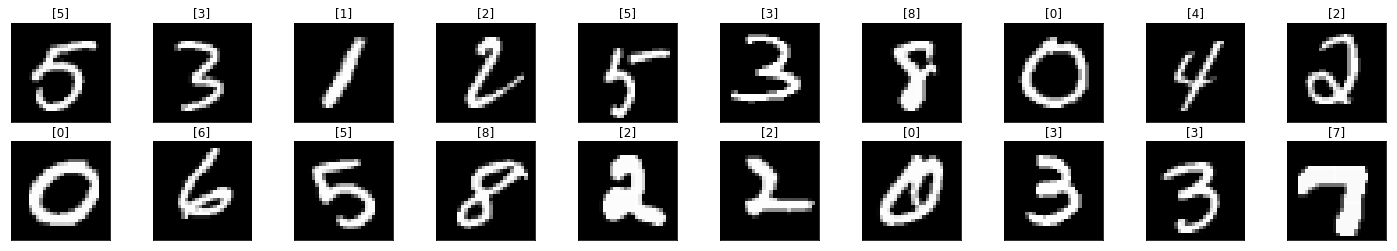

In [41]:
dataiter = iter(training_loader) #iterable
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in range(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks = [], yticks=[]) #set ticks as empty
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])

## Model

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 20, 5, 1) #input_channels, number of output channels(filters), kernel size, stride
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(4*4*50, 500) #fully connected layer(dimension: 28-4 > 24 >/2 > 12 > -4>8>/2>4)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2) #kernel size = 2, stride = 2
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*50)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x  

In [0]:
model = LeNet().to(device)

In [44]:
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [60]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  print (e, "/", epochs)
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader: #BATCH GRADIENT DESCENT
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
    #Be careful that len(training_loader) is the number of batches, not the total number of samples used, but since the batch_size is 100, thus the following directly gives us the percentage value.
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
        

0 / 15
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15


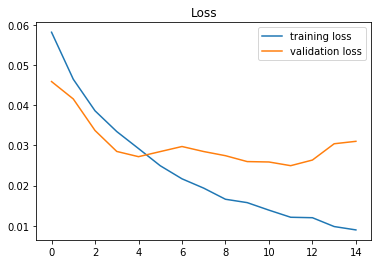

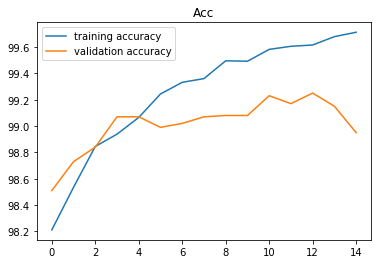

In [61]:
plt.title('Loss')
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()
plt.show()

plt.title('Acc')
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()
plt.show()

In [0]:
import PIL.ImageOps

In [0]:
import requests
from PIL import Image

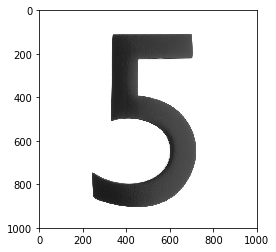

In [64]:
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

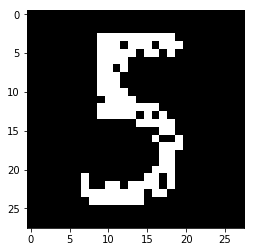

In [65]:
img = PIL.ImageOps.invert(img) #convert to black background and white forground
img = img.convert('1') #binary image - black white image
img = transform(img)
plt.imshow(im_convert(img))

In [66]:
img[0].shape

torch.Size([28, 28])

In [67]:
images = img.to(device)
print (images.shape)
image = images[0].unsqueeze(0).unsqueeze(0) #into shape of (batch_size, channel, width, height)
print (image.shape)
output = model.forward(image) #it is equivalent to model(img)
_, pred = torch.max(output, 1)
print (pred.item())

torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])
5


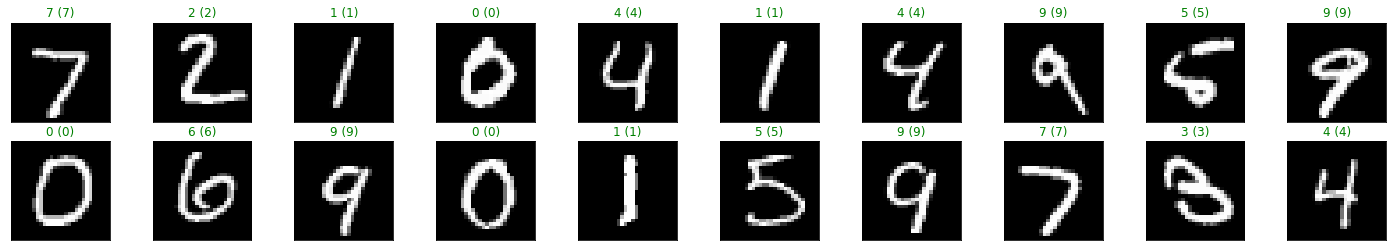

In [68]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device) #convert tensor to cuda tensor type
labels = labels.to(device)
output = model(images)
_, preds =torch.max(output, 1)

fig = plt.figure(figsize = (25, 4))

for idx in range(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = [])
  plt.imshow(im_convert(images[idx]))
  ax.set_title('{} ({})'.format(str(preds[idx].item()), str(labels[idx].item())), color = 'green' if preds[idx]==labels[idx] else "red")